In [53]:
import pandas as pd
import dataprep
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('loan_status_balanced.csv')

In [54]:
df

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,21.0,0,0,83732.0,0,3,15000.0,3,8.49,0.18,2.0,676,0,0
1,36.0,0,0,141689.0,16,0,15284.0,4,9.95,0.11,11.0,649,0,0
2,30.0,1,1,78995.0,10,3,20000.0,2,11.99,0.25,8.0,675,0,1
3,25.0,0,1,35824.0,4,3,4031.0,2,16.19,0.11,4.0,653,0,1
4,21.0,1,1,67645.0,1,3,5000.0,5,5.42,0.07,3.0,632,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14573,22.0,1,1,22704.0,0,3,3000.0,0,10.96,0.13,2.0,522,0,1
14574,21.0,0,4,49891.0,0,3,10400.0,4,9.32,0.21,3.0,524,1,0
14575,24.0,1,3,45798.0,0,3,14716.0,1,12.30,0.32,4.0,523,0,1
14576,25.0,1,3,24048.0,4,3,3800.0,0,14.35,0.16,4.0,600,0,1


In [55]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Separate features and target
X = df.drop(columns=['loan_status'])
y = df['loan_status']

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data and transform both sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [71]:
import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [56]:
# Verify the sizes
print(f"Training set size: {X_train_scaled.shape[0]}")
print(f"Test set size: {X_test_scaled.shape[0]}")

Training set size: 11662
Test set size: 2916


In [57]:
import optuna
import sklearn

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [24]:
# Replace SVM with CatBoost and MLP
models = {
    "Logistic Regression": LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

In [59]:
# Train and evaluate models
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Collect evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    confusion = confusion_matrix(y_test, y_pred)
    
    # Save results
    results[name] = {"accuracy": accuracy, "report": report, "confusion_matrix": confusion}

Model: Logistic Regression
Accuracy: 0.8717
Classification Report:
{'0': {'precision': 0.9106060606060606, 'recall': 0.8244170096021948, 'f1-score': 0.865370770338373, 'support': 1458.0}, '1': {'precision': 0.8395989974937343, 'recall': 0.9190672153635117, 'f1-score': 0.8775376555337263, 'support': 1458.0}, 'accuracy': 0.8717421124828533, 'macro avg': {'precision': 0.8751025290498975, 'recall': 0.8717421124828533, 'f1-score': 0.8714542129360496, 'support': 2916.0}, 'weighted avg': {'precision': 0.8751025290498975, 'recall': 0.8717421124828533, 'f1-score': 0.8714542129360497, 'support': 2916.0}}
Confusion Matrix:


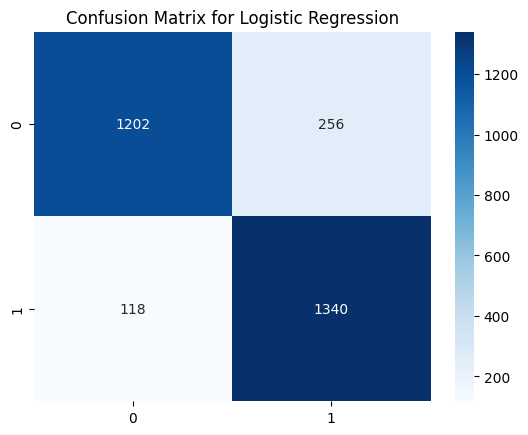

Model: Decision Tree
Accuracy: 0.8505
Classification Report:
{'0': {'precision': 0.85, 'recall': 0.8511659807956105, 'f1-score': 0.8505825908156271, 'support': 1458.0}, '1': {'precision': 0.8509615384615384, 'recall': 0.8497942386831275, 'f1-score': 0.8503774879890186, 'support': 1458.0}, 'accuracy': 0.850480109739369, 'macro avg': {'precision': 0.8504807692307692, 'recall': 0.850480109739369, 'f1-score': 0.8504800394023229, 'support': 2916.0}, 'weighted avg': {'precision': 0.8504807692307692, 'recall': 0.850480109739369, 'f1-score': 0.8504800394023229, 'support': 2916.0}}
Confusion Matrix:


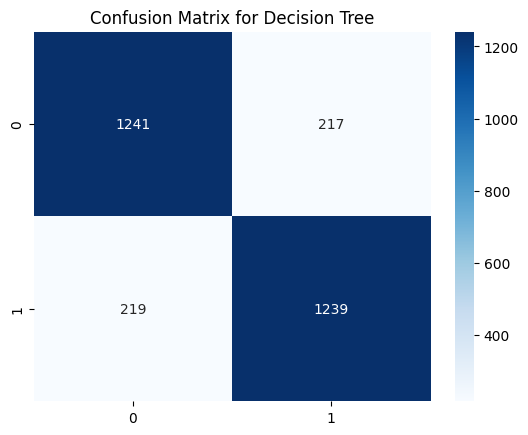

Model: Random Forest
Accuracy: 0.8909
Classification Report:
{'0': {'precision': 0.9136429608127722, 'recall': 0.8635116598079561, 'f1-score': 0.88787023977433, 'support': 1458.0}, '1': {'precision': 0.8706111833550065, 'recall': 0.9183813443072703, 'f1-score': 0.8938584779706275, 'support': 1458.0}, 'accuracy': 0.8909465020576132, 'macro avg': {'precision': 0.8921270720838894, 'recall': 0.8909465020576132, 'f1-score': 0.8908643588724787, 'support': 2916.0}, 'weighted avg': {'precision': 0.8921270720838894, 'recall': 0.8909465020576132, 'f1-score': 0.8908643588724787, 'support': 2916.0}}
Confusion Matrix:


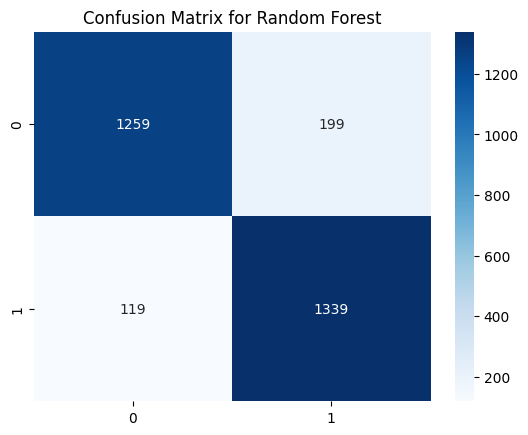

Model: XGBoost
Accuracy: 0.8975
Classification Report:
{'0': {'precision': 0.913633119200571, 'recall': 0.877914951989026, 'f1-score': 0.8954179783140959, 'support': 1458.0}, '1': {'precision': 0.8825082508250826, 'recall': 0.9170096021947873, 'f1-score': 0.8994281870164816, 'support': 1458.0}, 'accuracy': 0.8974622770919067, 'macro avg': {'precision': 0.8980706850128268, 'recall': 0.8974622770919067, 'f1-score': 0.8974230826652887, 'support': 2916.0}, 'weighted avg': {'precision': 0.8980706850128268, 'recall': 0.8974622770919067, 'f1-score': 0.8974230826652887, 'support': 2916.0}}
Confusion Matrix:


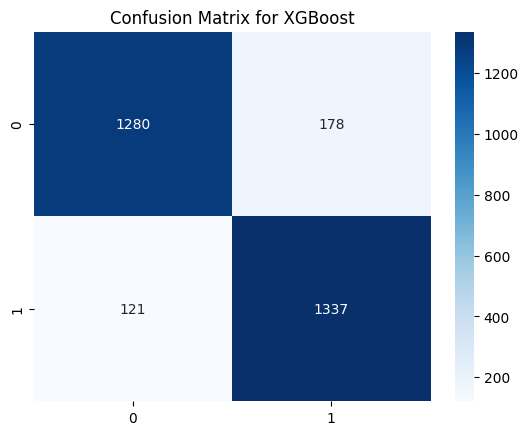

Model: CatBoost
Accuracy: 0.8947
Classification Report:
{'0': {'precision': 0.9185454545454546, 'recall': 0.8662551440329218, 'f1-score': 0.891634309918814, 'support': 1458.0}, '1': {'precision': 0.8734587929915639, 'recall': 0.9231824417009602, 'f1-score': 0.8976325441813938, 'support': 1458.0}, 'accuracy': 0.894718792866941, 'macro avg': {'precision': 0.8960021237685092, 'recall': 0.894718792866941, 'f1-score': 0.894633427050104, 'support': 2916.0}, 'weighted avg': {'precision': 0.8960021237685092, 'recall': 0.894718792866941, 'f1-score': 0.8946334270501038, 'support': 2916.0}}
Confusion Matrix:


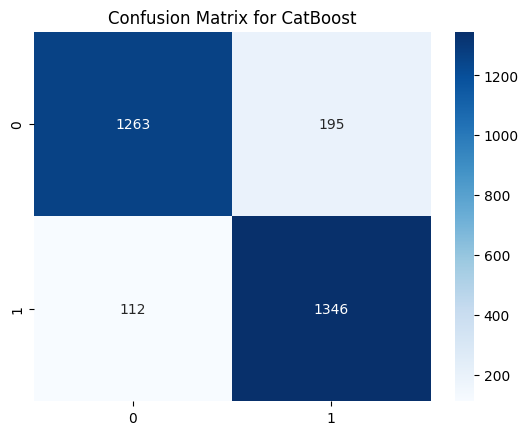

Model: MLP
Accuracy: 0.8453
Classification Report:
{'0': {'precision': 0.8583629893238434, 'recall': 0.8271604938271605, 'f1-score': 0.8424729304924904, 'support': 1458.0}, '1': {'precision': 0.8332230311052283, 'recall': 0.8635116598079561, 'f1-score': 0.8480970023576961, 'support': 1458.0}, 'accuracy': 0.8453360768175583, 'macro avg': {'precision': 0.8457930102145359, 'recall': 0.8453360768175583, 'f1-score': 0.8452849664250932, 'support': 2916.0}, 'weighted avg': {'precision': 0.8457930102145359, 'recall': 0.8453360768175583, 'f1-score': 0.8452849664250932, 'support': 2916.0}}
Confusion Matrix:


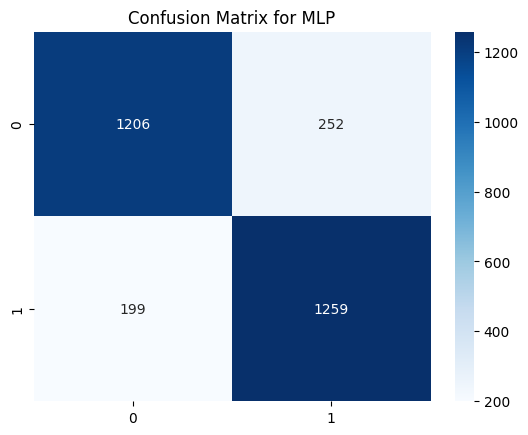

In [60]:
# DataFrame to store results
evaluation_table = pd.DataFrame(columns=["Model", "Loan Status (Encoded)", "Precision", "Recall", "F1 Score", "Support"])

# Visualization of Results
for name, result in results.items():
    print(f"Model: {name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print("Classification Report:")
    print(result['report'])
    print("Confusion Matrix:")
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {name}")
    plt.show()

    # Add classification report metrics to the table
    rows = []
    for loan_status, metrics in result["report"].items():
        if loan_status.isdigit():  # Filter only numeric health labels (encoded classes)
            rows.append({
                "Model": name,
                "Loan Status (Encoded)": loan_status,
                "Precision": metrics["precision"],
                "Recall": metrics["recall"],
                "F1 Score": metrics["f1-score"],
                "Support": metrics["support"]
            })
    
    # Concatenate rows into the DataFrame
    evaluation_table = pd.concat([evaluation_table, pd.DataFrame(rows)], ignore_index=True)

In [61]:
# Display the evaluation table
print("\nEvaluation Results in Tabular Format:")
evaluation_table


Evaluation Results in Tabular Format:


,Model,Loan Status (Encoded),Precision,Recall,F1 Score,Support
0,Logistic Regression,0,0.910606,0.824417,0.865371,1458.0
1,Logistic Regression,1,0.839599,0.919067,0.877538,1458.0
2,Decision Tree,0,0.850000,0.851166,0.850583,1458.0
3,Decision Tree,1,0.850962,0.849794,0.850377,1458.0
4,Random Forest,0,0.913643,0.863512,0.887870,1458.0
5,Random Forest,1,0.870611,0.918381,0.893858,1458.0
6,XGBoost,0,0.913633,0.877915,0.895418,1458.0
7,XGBoost,1,0.882508,0.917010,0.899428,1458.0
8,CatBoost,0,0.918545,0.866255,0.891634,1458.0
9,CatBoost,1,0.873459,0.923182,0.897633,1458.0


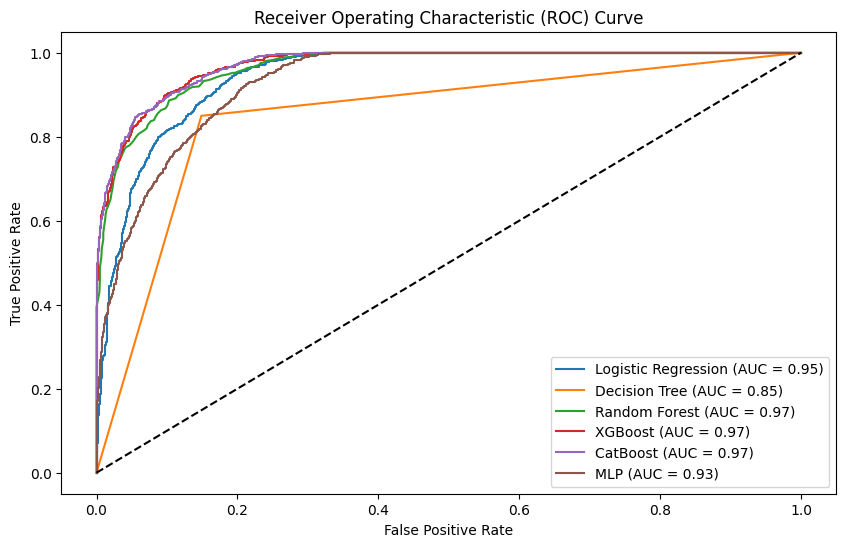

In [62]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for name, result in results.items():
    # Get the model and true labels
    model = models[name]
    y_true = y_test

    # Predict probabilities
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_probs = model.decision_function(X_test_scaled)
    
    # Compute ROC curve and AUC score
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


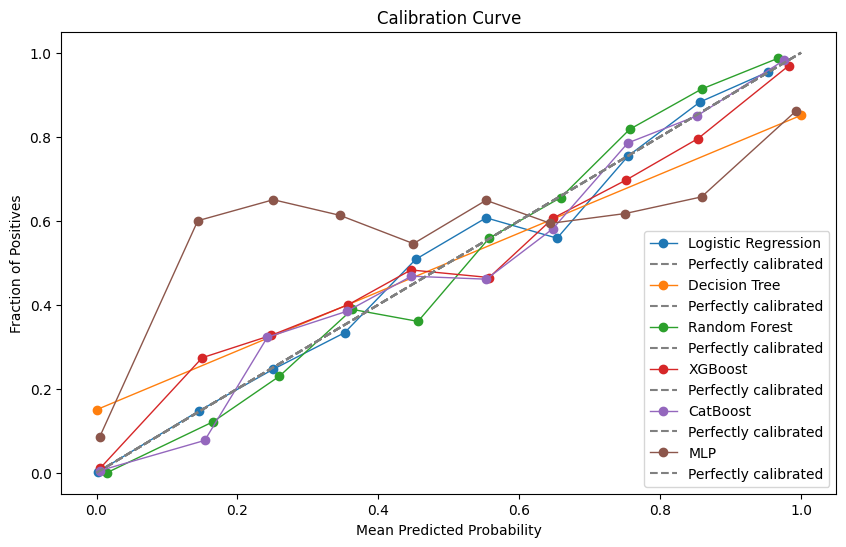

In [63]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Function to plot calibration curve
def plot_calibration_curve(y_true, y_probs, model_name, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_probs, n_bins=n_bins)

    plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label=f'{model_name}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')

    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Curve')
    plt.legend(loc='best')

plt.figure(figsize=(10, 6))

for name, model in models.items():
    y_true = y_test

    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_probs = model.decision_function(X_test_scaled)
    
    plot_calibration_curve(y_true, y_probs, name)

plt.show()


In [64]:
import optuna
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Define the objective function for Optuna
def objective(trial):
    # Select the model to tune
    model_name = trial.suggest_categorical("model", ["Random Forest", "CatBoost", "XGBoost"])

    if model_name == "Random Forest":
        # Hyperparameter suggestions for Random Forest
        n_estimators = trial.suggest_int("n_estimators", 50, 500)
        max_depth = trial.suggest_int("max_depth", 3, 15)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            class_weight="balanced",  # Handle class imbalance
            random_state=42
        )

    elif model_name == "CatBoost":
        # Hyperparameter suggestions for CatBoost
        iterations = trial.suggest_int("iterations", 50, 500)
        depth = trial.suggest_int("depth", 3, 10)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)

        model = CatBoostClassifier(
            iterations=iterations,
            depth=depth,
            learning_rate=learning_rate,
            task_type="GPU",  # Use GPU if available
            verbose=0,
            random_state=42
        )

    elif model_name == "XGBoost":
        # Hyperparameter suggestions for XGBoost
        n_estimators = trial.suggest_int("n_estimators", 50, 500)
        max_depth = trial.suggest_int("max_depth", 3, 15)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
        subsample = trial.suggest_float("subsample", 0.5, 1.0)
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
        gamma = trial.suggest_float("gamma", 0.0, 5.0)
        min_child_weight = trial.suggest_int("min_child_weight", 1, 10)

        model = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            min_child_weight=min_child_weight,
            use_label_encoder=False,
            eval_metric="logloss",
            tree_method="gpu_hist",  # Use GPU if available
            random_state=42
        )

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Predict probabilities on the test set
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Calculate and return the ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    return roc_auc

# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Display the best results
print("\n🎯 Best Model and Hyperparameters:")
print(f"Best Model: {study.best_params['model']}")
print(f"Best ROC-AUC: {study.best_value:.4f}")
print(f"Best Hyperparameters: {study.best_params}")


[I 2025-01-16 22:55:51,955] A new study created in memory with name: no-name-c8154b7a-54d4-4520-aff5-4e006759fef7
[I 2025-01-16 22:55:53,090] Trial 0 finished with value: 0.9687500588023881 and parameters: {'model': 'CatBoost', 'iterations': 190, 'depth': 7, 'learning_rate': 0.17649662069981312}. Best is trial 0 with value: 0.9687500588023881.
[I 2025-01-16 22:55:54,507] Trial 1 finished with value: 0.9649246106341061 and parameters: {'model': 'Random Forest', 'n_estimators': 150, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.9687500588023881.
[I 2025-01-16 22:55:57,103] Trial 2 finished with value: 0.9629846022418294 and parameters: {'model': 'Random Forest', 'n_estimators': 333, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.9687500588023881.
[I 2025-01-16 22:55:58,587] Trial 3 finished with value: 0.9710118338630254 and parameters: {'model': 'CatBoost', 'iterations': 298, 'depth': 4, 'le


🎯 Best Model and Hyperparameters:
Best Model: XGBoost
Best ROC-AUC: 0.9726
Best Hyperparameters: {'model': 'XGBoost', 'n_estimators': 382, 'max_depth': 4, 'learning_rate': 0.19432524658077177, 'subsample': 0.9194205382737372, 'colsample_bytree': 0.7854813570438084, 'gamma': 0.6274485393800924, 'min_child_weight': 2}


In [65]:
# Retrieve the best hyperparameters
best_params = study.best_params

# Train the model with the best hyperparameters on the training data
best_model = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    min_child_weight=best_params['min_child_weight'],
    use_label_encoder=False,
    eval_metric="logloss",
    tree_method="gpu_hist"  # Use GPU if available
)

# Fit the best model
best_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test_scaled)

In [66]:
# Evaluate performance
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.9005486968449932
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      1458
           1       0.88      0.92      0.90      1458

    accuracy                           0.90      2916
   macro avg       0.90      0.90      0.90      2916
weighted avg       0.90      0.90      0.90      2916



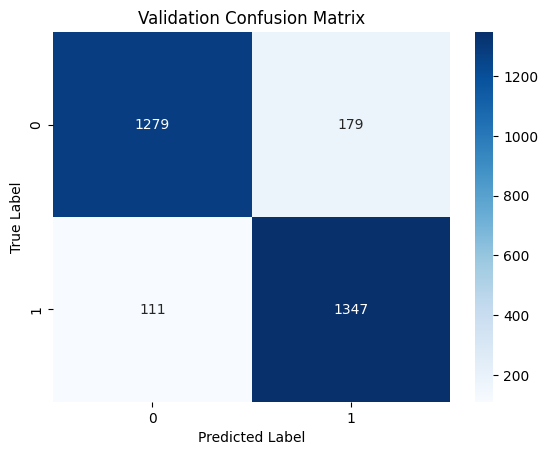

In [67]:
# Plot the confusion matrix for validation predictions
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [89]:
import joblib

# Save the model to a .pkl file
joblib.dump(best_model, "best_xgboost_model.pkl")
print("Model saved to best_xgboost_model.pkl")


Model saved to best_xgboost_model.pkl


In [74]:
import xgboost
print(xgboost.__version__)

2.1.3


In [69]:
# Load the model from the .pkl file
loaded_model = joblib.load("best_xgboost_model.pkl")
print("Model loaded successfully.")


Model loaded successfully.


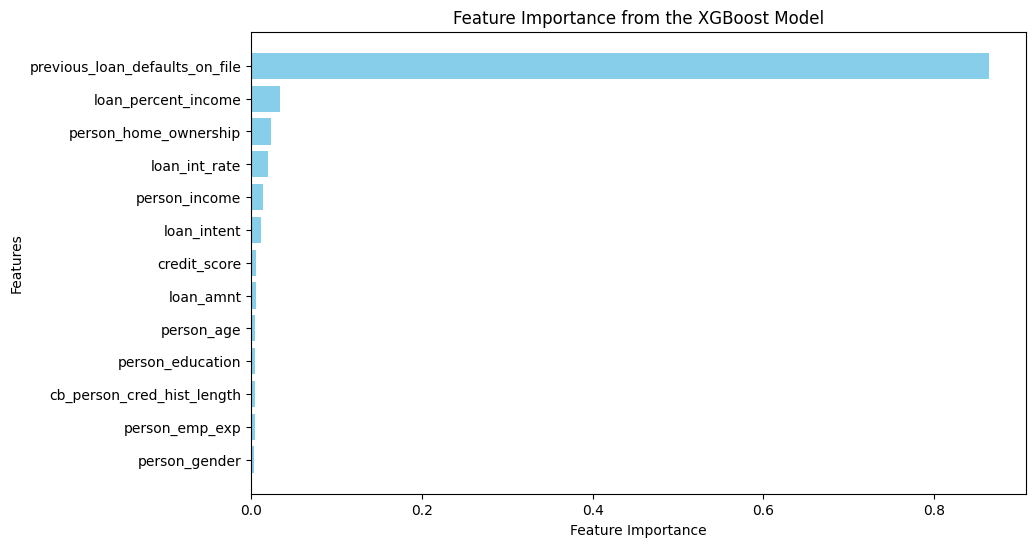

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance from the loaded model
feature_importance = loaded_model.feature_importances_
features = df.columns[:-1]  # Assuming the last column is the target variable

# Sort feature importance for better visualization
sorted_idx = np.argsort(feature_importance)
sorted_features = features[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importance, color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance from the XGBoost Model")
plt.show()


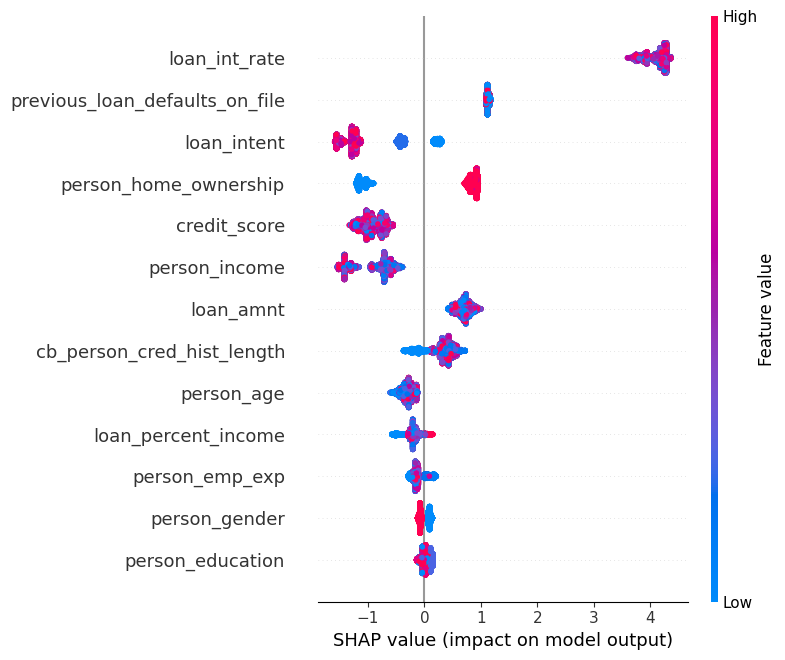

In [76]:
import shap

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(loaded_model)  # Use TreeExplainer for tree-based models like XGBoost
shap_values = explainer.shap_values(df.drop(columns=["loan_status"]))

# Global feature importance visualization
shap.summary_plot(shap_values, df.drop(columns=["loan_status"]))

# Local explanation for a single prediction
shap.force_plot(explainer.expected_value, shap_values[0], df.drop(columns=["loan_status"]).iloc[0])


In [79]:
from lime.lime_tabular import LimeTabularExplainer

# Initialize the LIME explainer
explainer = LimeTabularExplainer(
    training_data=np.array(df.drop(columns=["loan_status"])),
    feature_names=df.drop(columns=["loan_status"]).columns,
    class_names=["Rejected", "Approved"],
    mode="classification"
)

# Explain a single prediction
exp = explainer.explain_instance(
    data_row=df.drop(columns=["loan_status"]).iloc[0].values,
    predict_fn=loaded_model.predict_proba
)
exp.show_in_notebook()


In [87]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import numpy as np

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store scores
auc_scores = []

for train_index, test_index in kf.split(df):
    # Train the model
    loaded_model.fit(X_train_scaled, y_train)
    
    # Predict probabilities
    y_pred_proba = loaded_model.predict_proba(X_test_scaled)[:, 1]
    
    # Compute AUC score
    auc = roc_auc_score(y_test, y_pred_proba)
    auc_scores.append(auc)

print("Cross-validation AUC scores:", auc_scores)
print("Mean AUC:", np.mean(auc_scores))


Cross-validation AUC scores: [0.9679315295583141, 0.9679315295583141, 0.9679315295583141, 0.9679315295583141, 0.9679315295583141]
Mean AUC: 0.9679315295583141


In [96]:
df

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,21.0,0,0,83732.0,0,3,15000.0,3,8.49,0.18,2.0,676,0,0
1,36.0,0,0,141689.0,16,0,15284.0,4,9.95,0.11,11.0,649,0,0
2,30.0,1,1,78995.0,10,3,20000.0,2,11.99,0.25,8.0,675,0,1
3,25.0,0,1,35824.0,4,3,4031.0,2,16.19,0.11,4.0,653,0,1
4,21.0,1,1,67645.0,1,3,5000.0,5,5.42,0.07,3.0,632,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14573,22.0,1,1,22704.0,0,3,3000.0,0,10.96,0.13,2.0,522,0,1
14574,21.0,0,4,49891.0,0,3,10400.0,4,9.32,0.21,3.0,524,1,0
14575,24.0,1,3,45798.0,0,3,14716.0,1,12.30,0.32,4.0,523,0,1
14576,25.0,1,3,24048.0,4,3,3800.0,0,14.35,0.16,4.0,600,0,1


In [113]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np

# Identify columns to use for prediction
feature_columns = [col for col in df.columns if col != "loan_status"]  # Drop target column
sensitive_feature = df["previous_loan_defaults_on_file"]

# Drop unnecessary columns
X = df[feature_columns]

# Predict using the model
y_pred = loaded_model.predict(X)

sensitive_feature = df["previous_loan_defaults_on_file"]  # Replace with your sensitive feature
y_true = df["loan_status"]

# Define metrics to evaluate
metrics = {
    "Accuracy": accuracy_score,
    "ROC AUC": roc_auc_score
}

# Use Fairlearn's MetricFrame to calculate metrics across sensitive groups
metric_frame = MetricFrame(
    metrics=metrics,
    y_true=y_true,
    y_pred=y_pred,
    sensitive_features=sensitive_feature
)

# Display metrics
print("Overall Metrics:")
print(metric_frame.overall)

print("\nMetrics by Group:")
print(metric_frame.by_group)


ValueError: Feature shape mismatch, expected: 13, got 14